# ENSAE - Fairness in ML Project

First, I try to understand the AUC based fairness constraints:

Plotting these conditions directly as they are described in mathematical terms in the paper might not be straightforward without specific data or defined score distributions. However, you can visualize the concept by simulating data. Here’s a conceptual way to plot scenarios that might satisfy or violate these fairness constraints:

**Simulate Score Distributions:** Assume two groups with scores normally distributed but with different means and variances. Simulate these scores using Python.

**Calculate and Plot ROC Curves:** Use these scores to calculate and plot ROC curves for each group.

**Calculate AUCs:** Compute the AUC for these curves and visually inspect if they are similar (indicating fairness) or different.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

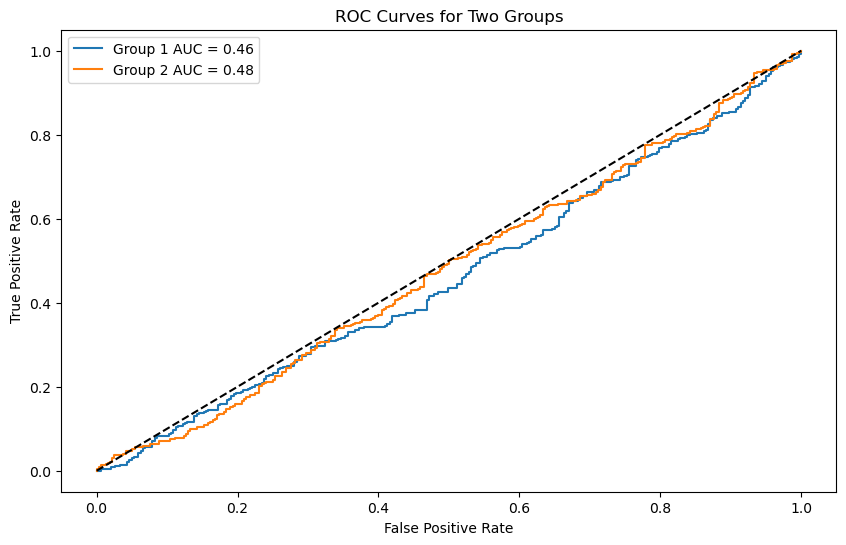

In [2]:
# Simulate scores for two groups
np.random.seed(42)
scores_group1 = np.random.normal(loc=0.5, scale=0.1, size=1000)
scores_group2 = np.random.normal(loc=0.6, scale=0.1, size=1000)

# True labels
labels_group1 = np.random.binomial(1, 0.7, 1000)
labels_group2 = np.random.binomial(1, 0.65, 1000)

# Compute ROC curve and AUC for each group
fpr1, tpr1, _ = roc_curve(labels_group1, scores_group1)
fpr2, tpr2, _ = roc_curve(labels_group2, scores_group2)
auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr2, tpr2)

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr1, tpr1, label=f'Group 1 AUC = {auc1:.2f}')
plt.plot(fpr2, tpr2, label=f'Group 2 AUC = {auc2:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Two Groups')
plt.legend()
plt.show()

In [3]:
# load the data to a pandas dataset
df = pd.read_csv("data/compas-scores-two-years.csv")
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [4]:
# Define the columns of interest and filter the df according to them

# vr = violent recidivism
    # r = recidivism
    # Types of crimes in the USA: felonies and misdemeanors
interesting_cols = [  # 'compas_screening_date',
    'sex',  # 'dob',
    'age', 'race',
    'juv_fel_count', 'decile_score', 'juv_misd_count',
    'juv_other_count', 'priors_count',
    'days_b_screening_arrest',
    'c_jail_in', 'c_jail_out',
    # 'c_offense_date', 'c_arrest_date',
    # 'c_days_from_compas',
    'c_charge_degree',
    # 'c_charge_desc',
    'is_recid',
    # 'r_charge_degree',
    # 'r_days_from_arrest', 'r_offense_date',  # 'r_charge_desc',
    # 'r_jail_in', 'r_jail_out',
    # 'is_violent_recid', 'num_vr_cases',  # 'vr_case_number',
    # 'vr_charge_degree', 'vr_offense_date',
    # 'vr_charge_desc', 'v_type_of_assessment',
    'v_decile_score',  # 'v_score_text',
    # 'v_screening_date',
    # 'type_of_assessment',
    'decile_score.1',  # 'score_text',
    # 'screening_date'
    ]

df = df[interesting_cols]

# Set pandas display options to show the full content of each field
pd.set_option('display.max_colwidth', None)

df.head()

,sex,age,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_charge_degree,is_recid,v_decile_score,decile_score.1
0,Male,69,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,F,0,1,1
1,Male,34,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,F,1,1,3
2,Male,24,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,F,1,3,4
3,Male,23,African-American,0,8,1,0,1,NaN,NaN,NaN,F,0,6,8
4,Male,43,Other,0,1,0,0,2,NaN,NaN,NaN,F,0,1,1


In [5]:
# Keep rows where the screening happened within 30 days before or after the arrest
df = df[(df["days_b_screening_arrest"] >= -30) & (df["days_b_screening_arrest"] <= 30)]

# Calculate the number of days each individual was in jail
df["days_in_jail"] = (pd.to_datetime(df["c_jail_out"]) - pd.to_datetime(df["c_jail_in"])).dt.days

# Filter out rows where recidivism data is not available or the charge degree is 'Other'
df = df[(df["is_recid"] >= 0) & (df["c_charge_degree"] != "O")]

# Prepare data for encoding and machine learning
cols_to_delete = ["c_jail_out", "c_jail_in", "days_b_screening_arrest"]
df = df[[a for a in df.columns if a not in cols_to_delete]]

df.head()

,sex,age,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,c_charge_degree,is_recid,v_decile_score,decile_score.1,days_in_jail
0,Male,69,Other,0,1,0,0,0,F,0,1,1,0
1,Male,34,African-American,0,3,0,0,0,F,1,1,3,10
2,Male,24,African-American,0,4,0,1,4,F,1,3,4,1
5,Male,44,Other,0,1,0,0,0,M,0,1,1,1
6,Male,41,Caucasian,0,6,0,0,14,F,1,2,6,6


In [6]:
# Define quantitative and qualitative columns for preprocessing
col_quanti = ["age", "juv_fel_count", "decile_score", "juv_misd_count", "priors_count",
                "v_decile_score", "decile_score.1", "days_in_jail"]
col_quali = ["race", "c_charge_degree"]

# Extract and transform qualitative (categorical) features
X_quali = df[col_quali].values
quali_encoder = OneHotEncoder(categories="auto")
quali_encoder.fit(X_quali)
X_quali = quali_encoder.transform(X_quali).toarray()

# Combine quantitative and qualitative data
X_quanti = df[col_quanti].values
X = np.concatenate([X_quanti, X_quali], axis=1)

In [7]:
# Define the target variable (recidivism) and sensitive attribute (race)
Z = np.array([int(x == "African-American") for x in df["race"]])
Y = 2 * df["is_recid"].values - 1  # Convert binary to -1, 1 format

# Split the data into training and test sets
TEST_SIZE_COMPAS = 0.2  # Assume a test size of 20%
X_train, X_test, Y_train, Y_test, Z_train, Z_test = train_test_split(
    X, Y, Z, test_size=TEST_SIZE_COMPAS, random_state=42)

# Scale the quantitative features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)